# Klasifikasi Gambar Sayur

## Import Libraries

In [1]:
# Mengimpor libraries umum untuk manipulasi file & data
import os, shutil, zipfile, random, pathlib
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io, img_as_ubyte, exposure, util
from skimage.transform import resize, rotate, AffineTransform, warp
from tensorflow.keras.preprocessing import image

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
!pip install tensorflowjs
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, SeparableConv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2, DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan agar output lebih bersih
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2025-05-19 22:40:17.451597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747694417.667157      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747694417.727037      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is 

## Data Loading

### Gabung data train, test dan validation ke direktori yang sama

In [2]:
# Path dataset awal
train_dir_old = "/kaggle/input/vegetable-image-dataset/Vegetable Images/train"
test_dir_old = "/kaggle/input/vegetable-image-dataset/Vegetable Images/test"
val_dir_old = "/kaggle/input/vegetable-image-dataset/Vegetable Images/validation"

# Path baru untuk menyimpan semua gambar sebelum pembagian ulang
combined_dir = "/kaggle/working/all_data"

# Buat direktori gabungan jika belum ada
os.makedirs(combined_dir, exist_ok=True)

# Gabungkan semua kategori dari train, test, dan validation
for old_dir in [train_dir_old, test_dir_old, val_dir_old]:
    for category in os.listdir(old_dir):  # Loop berdasarkan kategori sayuran
        category_dir_old = os.path.join(old_dir, category)
        category_dir_new = os.path.join(combined_dir, category)

        if os.path.isdir(category_dir_old):
            shutil.copytree(category_dir_old, category_dir_new, dirs_exist_ok=True)

# Cek apakah kategori masih tersusun dengan benar
print("Kategori dalam dataset setelah penggabungan:")
print(os.listdir(combined_dir))

Kategori dalam dataset setelah penggabungan:
['Capsicum', 'Brinjal', 'Bitter_Gourd', 'Cabbage', 'Tomato', 'Radish', 'Potato', 'Bean', 'Pumpkin', 'Broccoli', 'Cucumber', 'Carrot', 'Bottle_Gourd', 'Cauliflower', 'Papaya']


### Plot gambar sampel untuk semua kelas

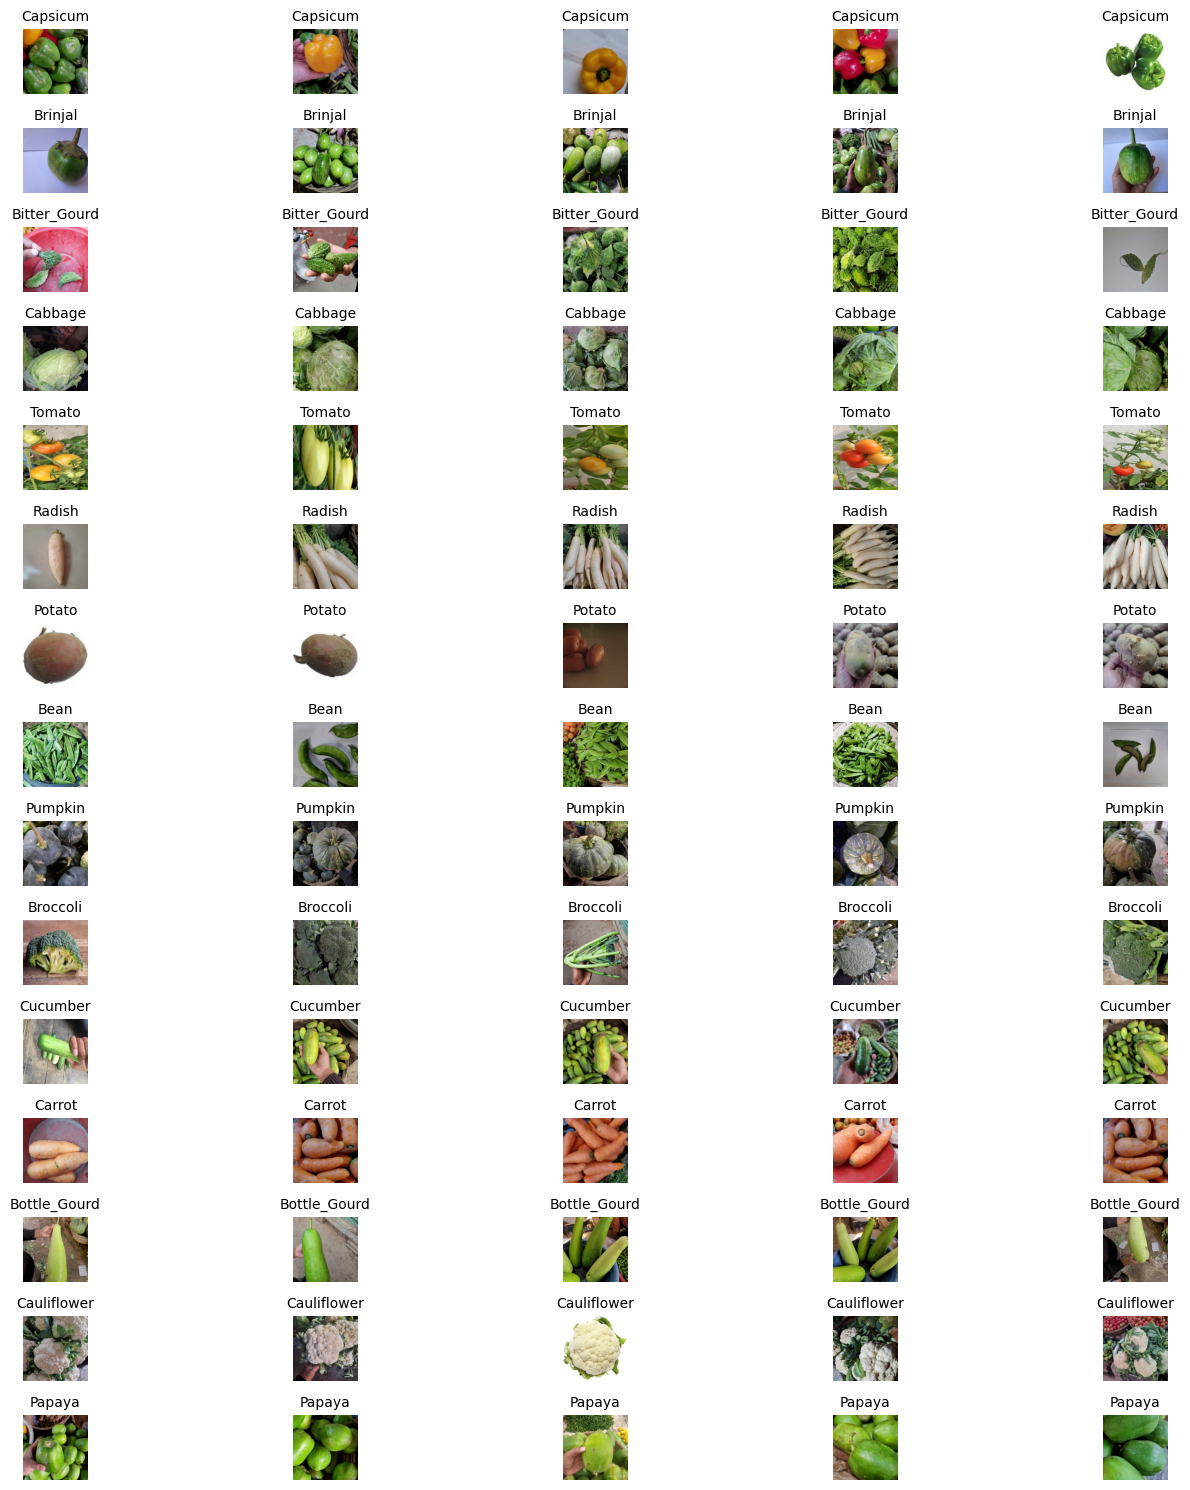

In [3]:
# Path dataset setelah penggabungan
dataset_path = "/kaggle/working/all_data"

# Membuat dictionary untuk menyimpan daftar gambar dari setiap kelas
class_images = {category: os.listdir(os.path.join(dataset_path, category)) for category in os.listdir(dataset_path)}

# Menampilkan secara acak 5 gambar dari setiap kelas
fig, axs = plt.subplots(len(class_images.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(class_images.keys()):
    images = np.random.choice(class_images[class_name], 5, replace=False)  # Pilih 5 gambar acak

    for j, image_name in enumerate(images):
        img_path = os.path.join(dataset_path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(class_name, fontsize=10)
        axs[i, j].axis("off")

fig.tight_layout()
plt.show()

### Plot distribusi gambar untuk semua kelas

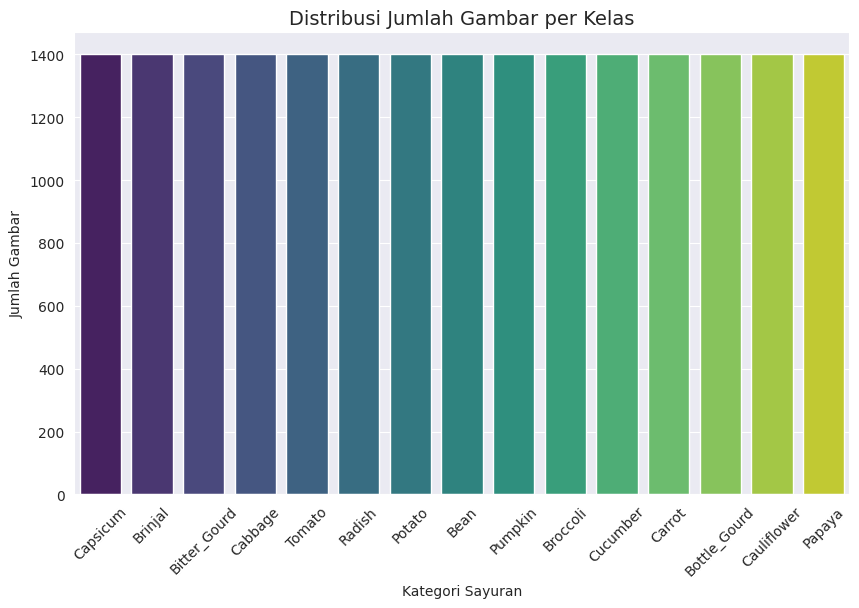

In [4]:
# Path dataset setelah penggabungan
dataset_path = "/kaggle/working/all_data"

# List untuk menyimpan informasi gambar
file_name = []
labels = []
full_path = []

# Loop untuk menyimpan semua gambar dan kategorinya
for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Buat DataFrame dari daftar file
distribution_df = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})

# Plot distribusi jumlah gambar per kelas
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
sns.countplot(x=distribution_df["labels"], palette="viridis")

# Rotasi label supaya tidak bertumpuk
plt.xticks(rotation=45)
plt.title("Distribusi Jumlah Gambar per Kelas", fontsize=14)
plt.xlabel("Kategori Sayuran")
plt.ylabel("Jumlah Gambar")
plt.show()

## Data Splitting: Train, Test & Validation

In [5]:
# Path dataset setelah penggabungan
dataset_path = "/kaggle/working/all_data"
final_dataset_path = "/kaggle/working/Dataset-Final"

# Membuat list path & label gambar
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Masukkan ke dalam DataFrame
df = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})

# Split dataset menjadi train (80%), test (10%), validation (10%)
X_train, X_test, y_train, y_test = train_test_split(df["path"], df["labels"], test_size=0.2, random_state=300, stratify=df["labels"])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=300, stratify=y_train)  # 10% dari train untuk validation

# Gabungkan hasil splitting ke dalam DataFrame baru
df_train = pd.DataFrame({"path": X_train, "labels": y_train, "set": "train"})
df_val = pd.DataFrame({"path": X_val, "labels": y_val, "set": "validation"})
df_test = pd.DataFrame({"path": X_test, "labels": y_test, "set": "test"})

df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

# Tampilkan jumlah data per kelas setelah splitting
print("=====================================================")
print(df_all.groupby(["set", "labels"]).size(), "\n")
print("=====================================================")

# Buat folder dan salin file ke dataset final
for index, row in tq(df_all.iterrows()):
    file_path = row["path"]
    label = row["labels"]
    data_set = row["set"]

    dest_dir = os.path.join(final_dataset_path, data_set, label)
    os.makedirs(dest_dir, exist_ok=True)  # Buat folder jika belum ada

    file_dest = os.path.join(dest_dir, file_path.split("/")[-1])
    shutil.copy2(file_path, file_dest)  # Salin file ke folder yang benar

set         labels      
test        Bean            280
            Bitter_Gourd    280
            Bottle_Gourd    280
            Brinjal         280
            Broccoli        280
            Cabbage         280
            Capsicum        280
            Carrot          280
            Cauliflower     280
            Cucumber        280
            Papaya          280
            Potato          280
            Pumpkin         280
            Radish          280
            Tomato          280
train       Bean            980
            Bitter_Gourd    980
            Bottle_Gourd    980
            Brinjal         980
            Broccoli        980
            Cabbage         980
            Capsicum        980
            Carrot          980
            Cauliflower     980
            Cucumber        980
            Papaya          980
            Potato          980
            Pumpkin         980
            Radish          980
            Tomato          980
validation  Bea

0it [00:00, ?it/s]

## Augmentasi
Proses augmentasi gambar adalah teknik yang digunakan untuk membuat variasi baru dari setiap gambar dalam dataset. **Tujuannya adalah meningkatkan kemampuan model dalam mengenali objek dalam berbagai kondisi**, sehingga dapat mencegah _overfitting_ dan meningkatkan generalisasi saat digunakan pada data baru. Pada _Vegetable Image Dataset_, kita menerapkan beberapa strategi augmentasi berikut:
1. **Rotasi Acak (`rotation_range=30`)**. Untuk meningkatkan ketahanan model terhadap perbedaan sudut pengambilan gambar.
2. **Translasi Horizontal & Vertikal (`width_shift_range=0.2, height_shift_range=0.2`)**. Membantu model mengenali sayuran meskipun posisinya berubah.
3. **Zoom Acak (`zoom_range=0.2`)**. Memungkinkan model untuk mengenali sayuran meskipun ukurannya sedikit berbeda.
4. **Brightness Adjustment (`brightness_range=[0.5, 1.5]`)**. Memungkinkan model tetap dapat mengenali objek di berbagai kondisi pencahayaan.
5. **Shearing (`shear_range=0.2`)**. Memungkinkan model lebih adaptif terhadap perubahan sudut kamera.
6. **Flip Horizontal (`horizontal_flip=True`)**. Untuk membantu model mengenali sayuran meskipun arahnya terbalik.
7. **Normalisasi (`rescale=1./255`)**. Mengubah nilai piksel dari **0-255 menjadi skala 0-1**, sehingga model lebih stabil saat belajar.

Karena sayuran memiliki **bentuk dan orientasi yang tetap**, kita **tidak menggunakan flip vertikal**, karena hal ini bisa membuat bentuk sayuran menjadi tidak realistis.

In [6]:
# Path dataset setelah splitting
train_path = "/kaggle/working/Dataset-Final/train"
val_path = "/kaggle/working/Dataset-Final/validation"

# Augmentasi untuk dataset training
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalisasi piksel
    rotation_range=30,     # Rotasi acak hingga 30 derajat
    width_shift_range=0.2, # Translasi horizontal
    height_shift_range=0.2,# Translasi vertikal
    zoom_range=0.2,        # Zoom acak hingga 20%
    brightness_range=[0.5, 1.5], # Penyesuaian kecerahan
    shear_range=0.2,       # Shearing atau pergeseran sudut
    horizontal_flip=True,  # Flip horizontal
    vertical_flip=False    # Flip vertikal tidak digunakan karena sayuran biasanya tetap orientasi
)

# Augmentasi lebih ringan untuk validation dataset (hanya normalisasi)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset dengan augmentasi
train_generator = train_datagen.flow_from_directory(
    train_path, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_path, target_size=(224, 224), batch_size=32, class_mode='categorical'
)

# Cek jumlah kelas untuk memastikan dataset terbaca dengan benar
print(f"Jumlah kelas dalam train set: {len(train_generator.class_indices)}")
print(f"Jumlah kelas dalam val set: {len(val_generator.class_indices)}")

Found 14700 images belonging to 15 classes.
Found 2100 images belonging to 15 classes.
Jumlah kelas dalam train set: 15
Jumlah kelas dalam val set: 15


## CNN Baseline Model
1. Menggunakan beberapa lapisan `Conv2D` untuk ekstraksi fitur dasar → memungkinkan model menangkap pola visual dari gambar sejak awal.  
2. MaxPooling2D setelah setiap `Conv2D` layer → mengurangi dimensi fitur dan meningkatkan efisiensi komputasi tanpa kehilangan informasi penting.  
3. Lapisan `Flatten` setelah ekstraksi fitur CNN → mengubah hasil dari convolusi menjadi vektor 1D agar bisa diproses oleh Fully Connected Layer.  
4. Dense layer dengan 128 neurons → membantu menangkap pola lebih kompleks sebelum output final.  
5. Output menggunakan softmax dengan 15 kelas → memastikan setiap kategori mendapatkan probabilitas klasifikasi.  
6. Optimizer: Adam → dipilih karena kemampuannya menyesuaikan learning rate secara adaptif selama training.  
7. Loss function: categorical_crossentropy → cocok untuk klasifikasi multi-kelas seperti pada dataset sayuran ini.  
8. Callbacks `EarlyStopping` dan `ReduceLROnPlateau` → menghentikan training jika tidak ada peningkatan dan menyesuaikan learning rate untuk efisiensi lebih baik.

In [9]:
# Reset session untuk CNN Baseline
tf.keras.backend.clear_session()

# Baseline Model dengan CNN
model_cnn_baseline = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(15, activation='softmax')  # Output dengan 15 kelas
])

# Compile model dengan optimizer Adam
model_cnn_baseline.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan arsitektur model
model_cnn_baseline.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,909,327 (91.21 MB)

 Trainable params: 23,909,327 (91.21 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
]

# Training CNN Baseline Model
history_cnn_baseline = model_cnn_baseline.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=callbacks
)

# Simpan model setelah training selesai
model_cnn_baseline.save("cnn_baseline_model.h5")
print("CNN Baseline Model selesai dilatih dan disimpan!")

Epoch 1/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 183s 380ms/step - accuracy: 0.3780 - loss: 2.0546 - val_accuracy: 0.6900 - val_loss: 0.9406 - learning_rate: 0.0010
Epoch 2/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 175s 375ms/step - accuracy: 0.6816 - loss: 0.9571 - val_accuracy: 0.8305 - val_loss: 0.5026 - learning_rate: 0.0010
Epoch 3/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 178s 382ms/step - accuracy: 0.7739 - loss: 0.6908 - val_accuracy: 0.8629 - val_loss: 0.4234 - learning_rate: 0.0010
Epoch 4/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 176s 377ms/step - accuracy: 0.8207 - loss: 0.5483 - val_accuracy: 0.8971 - val_loss: 0.3213 - learning_rate: 0.0010
Epoch 5/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 172s 368ms/step - accuracy: 0.8536 - loss: 0.4648 - val_accuracy: 0.9310 - val_loss: 0.2276 - learning_rate: 0.0010
Epoch 6/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 172s 368ms/step - accuracy: 0.8679 - loss: 0.4213 - val_accuracy: 0.9224 - val_loss: 0.2541 - learning_rate: 0.0010
Epoch 7/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 171s 367ms/step - accura

## ImageDataGenerator

In [12]:
# ImageDataGenerator untuk test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory="/kaggle/working/Dataset-Final/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Cek jumlah gambar di test set untuk memastikan semuanya terdeteksi
print(f"Total images in test set: {test_generator.n}")

Found 4200 images belonging to 15 classes.
Total images in test set: 4200


## Visualisasi dan Evaluasi

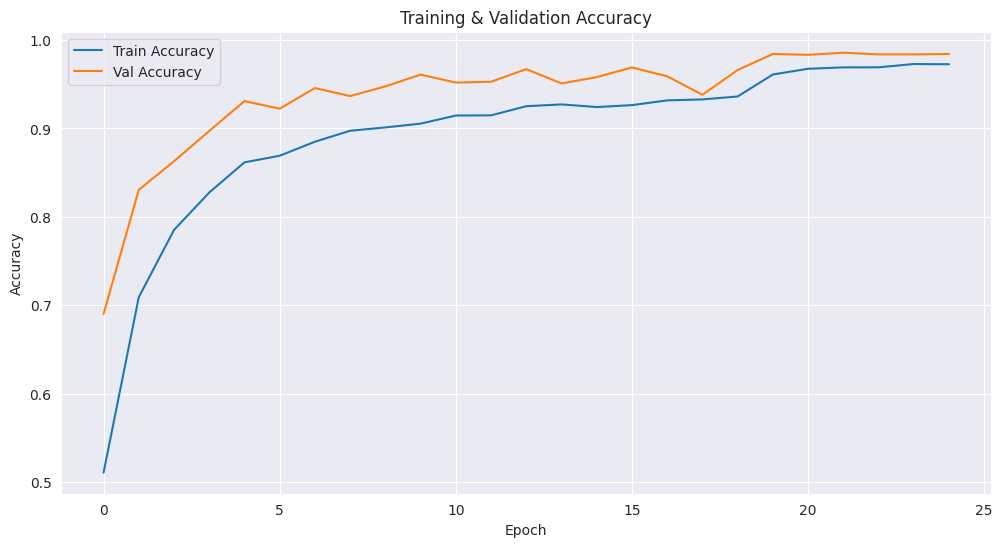

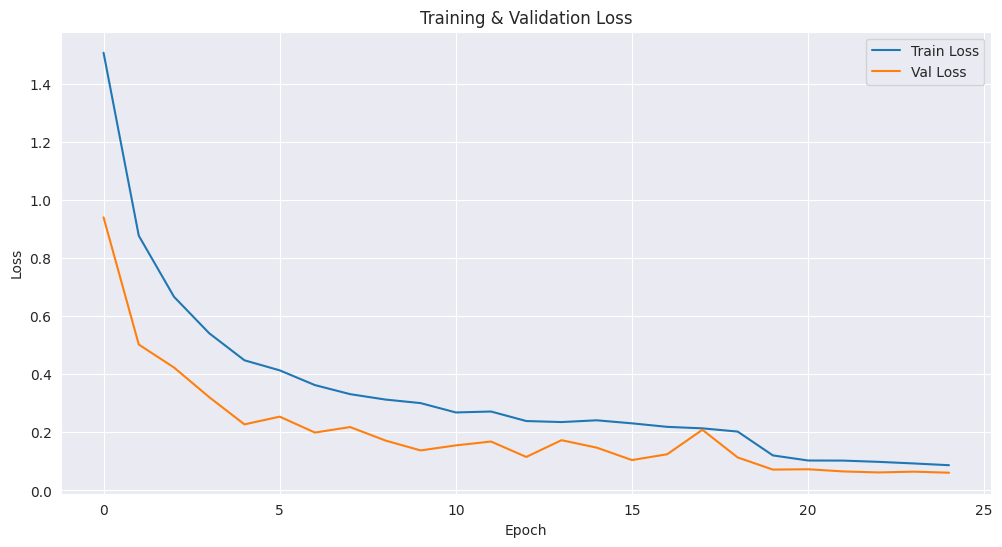

132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step


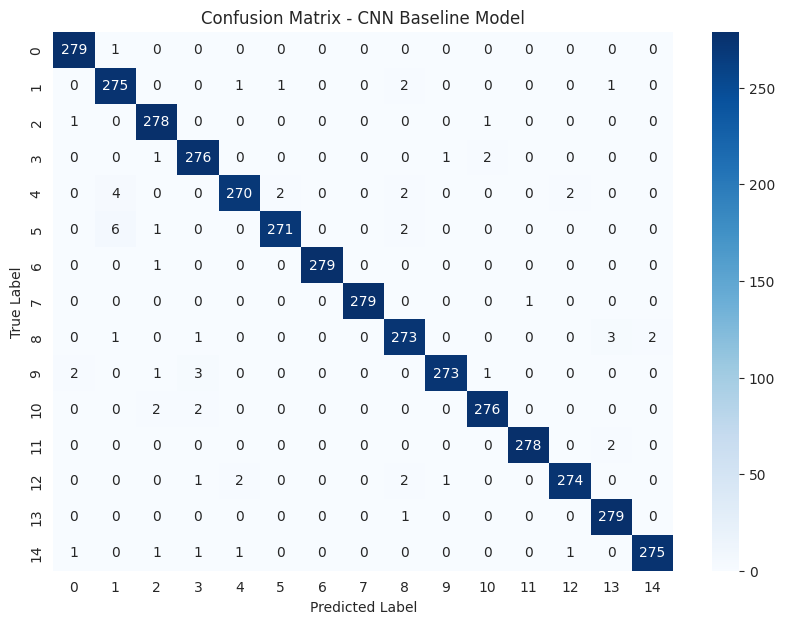

Classification Report CNN Baseline Model:
              precision    recall  f1-score   support

        Bean       0.99      1.00      0.99       280
Bitter_Gourd       0.96      0.98      0.97       280
Bottle_Gourd       0.98      0.99      0.98       280
     Brinjal       0.97      0.99      0.98       280
    Broccoli       0.99      0.96      0.97       280
     Cabbage       0.99      0.97      0.98       280
    Capsicum       1.00      1.00      1.00       280
      Carrot       1.00      1.00      1.00       280
 Cauliflower       0.97      0.97      0.97       280
    Cucumber       0.99      0.97      0.98       280
      Papaya       0.99      0.99      0.99       280
      Potato       1.00      0.99      0.99       280
     Pumpkin       0.99      0.98      0.98       280
      Radish       0.98      1.00      0.99       280
      Tomato       0.99      0.98      0.99       280

    accuracy                           0.98      4200
   macro avg       0.98      0.98     

In [13]:
# Visualisasi Akurasi dan Loss Model CNN Baseline
plt.figure(figsize=(12,6))
plt.plot(history_cnn_baseline.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn_baseline.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(history_cnn_baseline.history['loss'], label='Train Loss')
plt.plot(history_cnn_baseline.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

# Evaluasi dengan Confusion Matrix & Classification Report
y_true_cnn_baseline = test_generator.classes
y_pred_cnn_baseline = np.argmax(model_cnn_baseline.predict(test_generator), axis=1)

# Confusion Matrix
plt.figure(figsize=(10, 7))
cm_cnn_baseline = confusion_matrix(y_true_cnn_baseline, y_pred_cnn_baseline)
sns.heatmap(cm_cnn_baseline, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - CNN Baseline Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
print("Classification Report CNN Baseline Model:")
print(classification_report(y_true_cnn_baseline, y_pred_cnn_baseline, target_names=test_generator.class_indices.keys()))

## Save Model

In [16]:
# Pastikan daftar kelas ada
class_names = list(test_generator.class_indices.keys())

# Tentukan direktori penyimpanan
save_dir = "/kaggle/working/model"
os.makedirs(save_dir, exist_ok=True)

# Simpan model dalam format Keras sebelum konversi
model_cnn_baseline.save(os.path.join(save_dir, "model.keras"))

# Simpan dalam format TensorFlow SavedModel
saved_model_path = os.path.join(save_dir, "saved_model")
tf.saved_model.save(model_cnn_baseline, saved_model_path)

# Konversi ke TFLite dari SavedModel
tflite_path = os.path.join(save_dir, "tflite")
os.makedirs(tflite_path, exist_ok=True)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()
with open(os.path.join(tflite_path, "model.tflite"), "wb") as f:
    f.write(tflite_model)

# Tambah label.txt sesuai kelas pada test_generator
label_path = os.path.join(tflite_path, "label.txt")
with open(label_path, "w") as f:
    f.write("\n".join(class_names))

# Konversi ke TensorFlow.js dari Keras Model
tfjs_path = os.path.join(save_dir, "tfjs_model")
os.makedirs(tfjs_path, exist_ok=True)
tfjs.converters.save_keras_model(model_cnn_baseline, tfjs_path)

# ZIP semua file submission biar gampang di-download
shutil.make_archive("/kaggle/working/model", 'zip', save_dir)

print("Model berhasil dikonversi ke SavedModel, TF-Lite, dan TFJS!")

W0000 00:00:1747705116.110481      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1747705116.110526      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1747705116.118619      31 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil dikonversi ke SavedModel, TF-Lite, dan TFJS!


## Inferences

Masukkan path gambar (atau ketik 'exit' untuk keluar):  /kaggle/working/Dataset-Final/test/Papaya/0094.jpg


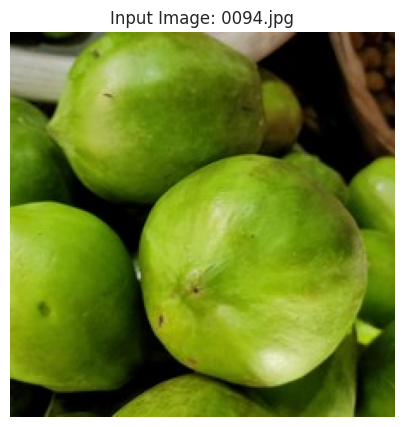

Model memprediksi gambar ini sebagai: Papaya (Confidence: 0.99)




Mau cek gambar lain? (ketik 'y' untuk lanjut, 'n' untuk keluar):  y
Masukkan path gambar (atau ketik 'exit' untuk keluar):  /kaggle/working/Dataset-Final/test/Tomato/0169.jpg


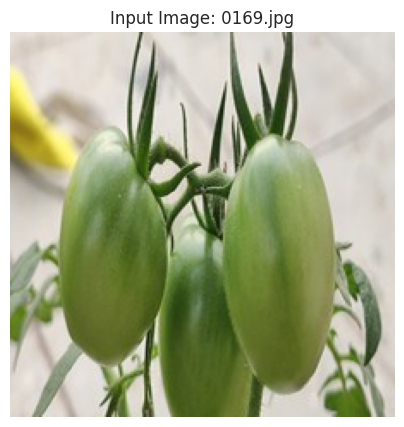

Model memprediksi gambar ini sebagai: Tomato (Confidence: 1.00)




Mau cek gambar lain? (ketik 'y' untuk lanjut, 'n' untuk keluar):  n


Keluar dari mode inferensi


In [18]:
# Load model dari format SavedModel
model = tf.saved_model.load("/kaggle/working/model/saved_model")
infer = model.signatures["serving_default"]

# Ambil key output dari model
output_key = list(infer.structured_outputs.keys())[0]

# Ambil daftar nama kelas dari test_generator
class_names = list(test_generator.class_indices.keys())

# Loop untuk mengecek beberapa gambar secara interaktif
while True:
    # Masukkan path gambar yang ingin diuji
    img_path = input("Masukkan path gambar (atau ketik 'exit' untuk keluar): ")
    
    if img_path.lower() == "exit":
        print("Keluar dari mode inferensi")
        break

    # Load gambar dan tampilkan
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Tambah batch dimension

    # Tampilkan gambar input
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Input Image: {img_path.split('/')[-1]}")
    plt.show()
    
    # Konversi ke Tensor untuk inferensi
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    # Jalankan prediksi
    predictions = infer(img_tensor)[output_key]

    # Ambil indeks kelas dengan probabilitas tertinggi
    predicted_class_idx = np.argmax(predictions.numpy()[0])

    # Dapatkan label kelas dan confidence score
    predicted_label = class_names[predicted_class_idx]
    confidence = np.max(predictions.numpy()[0])

    # Tampilkan hasil prediksi dengan confidence
    print(f"Model memprediksi gambar ini sebagai: {predicted_label} (Confidence: {confidence:.2f})\n")

    # Pilihan untuk lanjut atau keluar
    lanjut = input("\nMau cek gambar lain? (ketik 'y' untuk lanjut, 'n' untuk keluar): ")
    if lanjut.lower() != "y":
        print("Keluar dari mode inferensi")
        break

In [19]:
import pkg_resources

# Ambil semua library yang terinstal beserta versinya
installed_packages = pkg_resources.working_set
requirements = "\n".join([f"{pkg.project_name}=={pkg.version}" for pkg in installed_packages])

# Simpan ke requirements.txt
with open("requirements.txt", "w") as f:
    f.write(requirements)

print("requirements.txt berhasil dibuat!")

requirements.txt berhasil dibuat!
